
# 📓 SMS Spam Detection — Auto Notebook (Ensemble: NB + SVM + RF)

This notebook **runs end-to-end** on **Run All**:
- Loads dataset (`smsspam.csv` from `./data`, `../data`, or project root)
- Trains an **ensemble** (Naive Bayes + Calibrated Linear SVM + Random Forest)
- Prints **accuracy, ROC-AUC**, **classification report**
- Plots **confusion matrix**
- Saves artifacts under `models/` for the Streamlit app


In [1]:

# ---- Imports
import json, pickle
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [2]:

# ---- Paths (auto-detect dataset) & models dir
ROOT = Path.cwd()

possible_paths = [
    ROOT / "data" / "smsspam.csv",
    ROOT.parent / "data" / "smsspam.csv",
    ROOT / "smsspam.csv",
    ROOT.parent / "smsspam.csv",
]

DATA_PATH = None
for p in possible_paths:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise RuntimeError("❌ smsspam.csv not found. Put it in ./data or the project root.")

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Using dataset:", DATA_PATH.resolve())
print("📁 Artifacts will be saved to:", MODELS_DIR.resolve())


✅ Using dataset: C:\Users\Asus\Downloads\sms_spam_ensemble_pkg\data\smsspam.csv
📁 Artifacts will be saved to: C:\Users\Asus\Downloads\sms_spam_ensemble_pkg\notebooks\models


In [3]:

# ---- Load dataset (supports label/message or v1/v2 formats)
def load_dataset(path: Path) -> pd.DataFrame:
    df = None
    for enc in ("utf-8", "latin1", "cp1252"):
        try:
            df = pd.read_csv(path, encoding=enc, on_bad_lines="skip")
            break
        except Exception:
            pass
    if df is None:
        raise RuntimeError(f"Could not read CSV at {path}")
    cols = [c.lower() for c in df.columns]
    if "label" in cols and "message" in cols:
        df = df.rename(columns={df.columns[cols.index('label')]: "label",
                                df.columns[cols.index('message')]: "message"})
    elif "v1" in cols and "v2" in cols:
        df = df.rename(columns={df.columns[cols.index('v1')]: "label",
                                df.columns[cols.index('v2')]: "message"})
    else:
        df = df.iloc[:, :2]; df.columns = ["label", "message"]
    df = df.dropna(subset=["label","message"]).copy()
    df["label"] = df["label"].astype(str).str.strip().str.lower()
    df = df[df["label"].isin(["ham","spam"])].reset_index(drop=True)
    print("Counts:", Counter(df["label"]))
    return df

df = load_dataset(DATA_PATH)
print("Total messages:", len(df))
df.head()


Counts: Counter({'spam': 5000, 'ham': 5000})
Total messages: 10000


,label,message,char_count,word_count,avg_word_length,exclamation_count,financial_words,urgency_words,action_words,phone_numbers,urls,emoji_count,slang_score,language_mix_ratio,capitalization_ratio,profanity_count,url_is_suspicious,url_is_registered,platform,sender_type
0,spam,Win NFT mint pass! Go bit.ly/fomo now. Only fo...,72,14,3.857,1,1,1,0,0,1,1,0,0.0,0.111,0,1,0,Instagram,user
1,ham,u still down for movie? tickets at 7 पनि,40,9,3.333,0,0,0,0,0,0,0,0,0.1,0.000,0,0,0,Instagram,business
2,spam,Low-key insane cashback ₹2000 when you shop at...,84,15,4.333,0,1,0,1,0,1,1,0,0.0,0.071,0,1,1,SMS,unknown
3,ham,"brb, stuck in class rn. ttyl 🙂",30,6,3.500,0,0,0,0,0,0,1,1,0.0,0.000,0,0,0,Telegram,business
4,spam,Low-key insane cashback 50 followers when you ...,91,16,4.500,0,1,0,1,0,1,1,0,0.0,0.055,0,1,1,Instagram,unknown


In [4]:

# ---- Split & Vectorize
y = df["label"].map({"ham": 0, "spam": 1})
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["message"], y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words="english",
)

X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

len(X_train_text), len(X_test_text)


(8000, 2000)

In [5]:

# ---- Models & Ensemble
nb = MultinomialNB(alpha=0.1)
svm = CalibratedClassifierCV(LinearSVC(), cv=3)
rf  = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

ens = VotingClassifier(
    estimators=[("nb", nb), ("svm", svm), ("rf", rf)],
    voting="soft",
    weights=[1.0, 1.2, 1.0]
)
ens.fit(X_train, y_train)
"trained"


'trained'

In [6]:

# ---- Evaluate
y_pred = ens.predict(X_test)
try:
    y_prob = ens.predict_proba(X_test)[:, 1]
except Exception:
    y_prob = np.full_like(y_pred, np.nan, dtype=float)

acc = accuracy_score(y_test, y_pred)
try:
    auc = roc_auc_score(y_test, y_prob[~np.isnan(y_prob)])
except Exception:
    auc = float("nan")
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}" if np.isfinite(auc) else "ROC-AUC: N/A")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["ham", "spam"]))
print("Confusion Matrix:\n", cm)


Accuracy: 1.0000
ROC-AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1000
        spam       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
 [[1000    0]
 [   0 1000]]


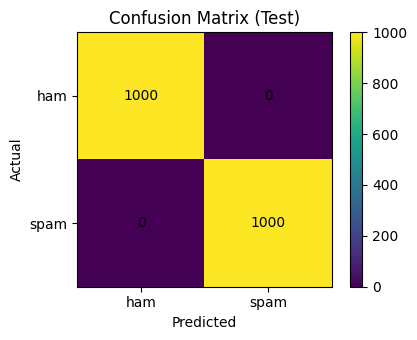

In [7]:

# ---- Plot confusion matrix
fig = plt.figure(figsize=(4.5, 3.5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0,1], ["ham","spam"]); plt.yticks([0,1],["ham","spam"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()


In [8]:

# ---- Save artifacts for Streamlit app
with open(MODELS_DIR / "vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open(MODELS_DIR / "ensemble_model.pkl", "wb") as f:
    pickle.dump(ens, f)
with open(MODELS_DIR / "label_encoder.pkl", "wb") as f:
    pickle.dump({"label_to_int": {"ham": 0, "spam": 1}, "int_to_label": {0: "ham", 1: "spam"}}, f)

with open(MODELS_DIR / "test_metrics.json", "w") as f:
    json.dump({"accuracy": float(acc), "roc_auc": (float(auc) if np.isfinite(auc) else None), "confusion_matrix": cm.tolist()}, f, indent=2)

pd.DataFrame({
    "message": X_test_text.reset_index(drop=True),
    "true_label": ["ham" if i == 0 else "spam" for i in y_test],
    "pred_label": ["ham" if i == 0 else "spam" for i in y_pred],
    "spam_probability": y_prob,
}).to_csv(MODELS_DIR / "test_predictions.csv", index=False)

print("✅ Artifacts saved to:", MODELS_DIR.resolve())


✅ Artifacts saved to: C:\Users\Asus\Downloads\sms_spam_ensemble_pkg\notebooks\models
